# Blobs classification 7 Tensorboard

For reference on the workflow:

https://medium.com/analytics-vidhya/distributed-training-in-pytorch-part-1-distributed-data-parallel-ae5c645e74cb

https://tuni-itc.github.io/wiki/Technical-Notes/Distributed_dataparallel_pytorch/

In [1]:
import torch
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import subprocess, os

# Graphics settings
mpl.rcParams['xtick.color'] = 'grey'
mpl.rcParams['ytick.color'] = 'grey'
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['axes.grid'] = False
# mpl.rcParams['xtick.labelsize'] = 10
# mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.labelcolor'] = 'grey'
mpl.rcParams['font.size'] = 15
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.edgecolor'] = 'grey'
mpl.rcParams['text.color'] = 'grey'
mpl.rcParams['xtick.minor.visible'] = False
mpl.rcParams['ytick.minor.visible'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.loc'] = 'upper left'
mpl.rcParams['figure.constrained_layout.h_pad'] = 0.12
mpl.rcParams['figure.constrained_layout.w_pad'] = 0.12
mpl.rcParams['figure.max_open_warning'] = 200

### Device / dtypes settings

In [2]:
params = {}

if torch.cuda.is_available():
    params['device'] = torch.device('cuda')
else:
    params['device'] = torch.device('cpu')

params['dtypes'] = {'X': np.float32, 'y': np.int64}

params['n_epochs'] = 60

params['train_batch_size'] = 1_00

params['n_hidden_layers'] = 20
params['hidden_layers_size'] = 20

params['learning_rate'] = 1e-2

#regularization
params['dropout_p'] = 0.2
params['l2_lambda'] = 1e-6

params['n_samples'] = 20_000

params

{'device': device(type='cpu'),
 'dtypes': {'X': numpy.float32, 'y': numpy.int64},
 'n_epochs': 60,
 'train_batch_size': 100,
 'n_hidden_layers': 20,
 'hidden_layers_size': 20,
 'learning_rate': 0.01,
 'dropout_p': 0.2,
 'l2_lambda': 1e-06,
 'n_samples': 20000}

## Dataset

In [243]:
def generate_dataset() -> None:
    import sklearn.datasets
    import sklearn.model_selection
    
    X, y = sklearn.datasets.make_blobs(
        n_samples=params['n_samples'],
        centers=6,
        cluster_std=1.1,
        random_state=0
    )

    # generate a downsampling mask for each class to a given amount
    y_probs = y.copy().astype('f4')
    y_probs[y_probs == 0] = 0.99
    y_probs[y_probs == 1] = 0.1
    y_probs[y_probs == 2] = 0.5
    y_probs[y_probs == 3] = 0.4
    y_probs[y_probs == 4] = 0.9
    y_probs[y_probs == 5] = 0.2

    torch.manual_seed(0)
    mask = (
        torch.bernoulli(
            torch.from_numpy(y_probs)
            .to(torch.float32)
        )
        .to(torch.bool)
        .numpy()
    )

    # merge some classes
    #y[y == 3] = 1
    y[y == 2] = 5
    y[y == 4] = 0

    # downsample
    X = X[mask, :]
    y = y[mask]

    
    # split to train and test
    (
        X_train, 
        X_test, 
        y_train, 
        y_test
    ) = sklearn.model_selection.train_test_split(
        X, 
        y, 
        train_size = 0.6,
        random_state = 0
    )
    
    return (
        X_train, 
        X_test, 
        y_train, 
        y_test
    )
    
(
    X_train, 
    X_test, 
    y_train, 
    y_test
) = generate_dataset()

In [244]:
X_train[:10, :], y_train[:10], np.unique(y_train, return_counts=True)

(array([[ 9.2152513 , -2.94672825],
        [-1.91869589,  8.81850199],
        [ 8.11568825, -2.42774328],
        [-1.7940576 ,  7.61005755],
        [ 8.56267352, -4.03849104],
        [ 0.1085238 ,  2.89243567],
        [ 0.16296401,  3.24734784],
        [ 1.55969769,  4.92854995],
        [ 1.278382  ,  3.63980485],
        [ 1.55187441,  4.11508636]]),
 array([0, 3, 0, 3, 0, 0, 5, 0, 0, 0]),
 (array([0, 1, 3, 5]), array([3753,  208,  793, 1379])))

In [245]:
np.save('datasets/X_train.npy', X_train)

In [246]:
np.save('datasets/X_test.npy', X_test)

In [247]:
np.save('datasets/y_train.npy', y_train)

In [248]:
np.save('datasets/y_test.npy', y_test)

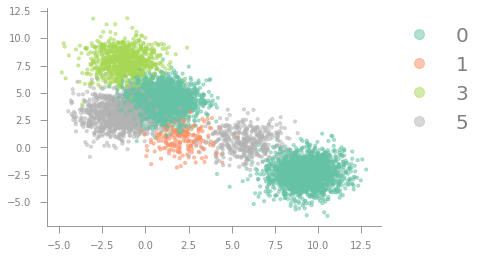

In [249]:
fig = plt.figure(1)
ax = fig.add_subplot()
pl1 = ax.scatter(*X_train.T, c=y_train, cmap='Set2', s=10, alpha = 0.5)
_ = ax.legend(
    *pl1.legend_elements(prop='colors', size=10),
    bbox_to_anchor=(1,1),
    fontsize=20
)   


## Transform the data straight away

Reason: so there is no need in the scripted version to setup all the transformers and recreate the torch.dataset object

In [250]:
# the ordinal encoder must be fit and used to transform with a 2 d array (dim 0 being the observations)
y_ordinal_encoder = (
    sklearn
    .preprocessing
    .OrdinalEncoder()
    .fit(y_train[:, None])
)

X_standard_scaler = (
    sklearn
    .preprocessing
    .StandardScaler()
    .fit(X_train)
)

In [251]:
X_train = X_standard_scaler.transform(X_train)
X_train

array([[ 1.37156519, -1.43575811],
       [-1.09992439,  1.81025806],
       [ 1.12748655, -1.29257063],
       ...,
       [ 1.21046209, -1.56478523],
       [ 0.07306586,  0.52028026],
       [-0.90614404,  0.76284207]])

In [252]:
y_train = y_ordinal_encoder.transform(y_train[:, None]).squeeze() # need to add a dimension to fit, after that it has to be removed (squeezed)
y_train

array([0., 2., 0., ..., 0., 0., 0.])

In [253]:
X_test = X_standard_scaler.transform(X_test)
X_test

array([[-0.02946771, -0.42336745],
       [ 0.48449134, -0.33642917],
       [ 0.57469718, -0.27531758],
       ...,
       [-1.05871475,  1.53604257],
       [ 1.30979381, -1.32904444],
       [-0.6179556 ,  0.85869766]])

In [254]:
y_test = y_ordinal_encoder.transform(y_test[:, None]).squeeze() # need to add a dimension to fit, after that it has to be removed (squeezed)
y_test

array([3., 3., 3., ..., 2., 0., 0.])

In [255]:
np.save('datasets/X_train_transformed.npy', X_train)

In [256]:
np.save('datasets/X_test_transformed.npy', X_test)

In [257]:
np.save('datasets/y_train_transformed.npy', y_train)

In [258]:
np.save('datasets/y_test_transformed.npy', y_test)

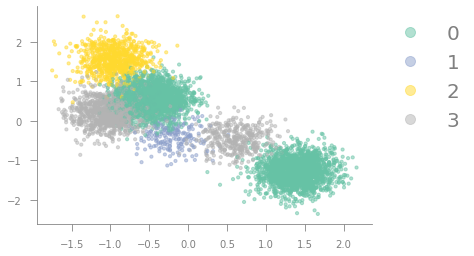

In [259]:
fig = plt.figure(1)
ax = fig.add_subplot()
pl1 = ax.scatter(
    *X_train.T,
    c=y_train, 
    cmap='Set2', s=10, alpha = 0.5
)
_ = ax.legend(
    *pl1.legend_elements(prop='colors', size=10),
    bbox_to_anchor=(1,1),
    fontsize=20
)   


## Setup the dataset

In [3]:
class Dataset_(torch.utils.data.Dataset):
    def __init__(self, 
                 X, 
                 y, 
                 X_transformer = None, 
                 y_transformer = None, 
                 X_dtype = np.float32,
                 y_dtype = np.int64):
        
        self.X = X
        self.y = y
        self.X_transformer = X_transformer
        self.y_transformer = y_transformer
        self.n_items = X.shape[0]
        self.n_features_in = X.shape[1]
        self.X_dtype = X_dtype
        self.y_dtype = y_dtype
        
        # setup the weights
        features_out, counts = np.unique(y, return_counts = True)
        n_features_out = len(features_out)
        self.balanced_dataset_size = int(np.min(counts) * n_features_out)
        average_weight = 1 / n_features_out
        
        # assign to each class a weight 
        # (lower representec classes have larger weights)
        features_out_weights = {}
        for feature_out in features_out:
            feature_out_proportion = (
                np.sum(y == feature_out) / 
                self.n_items
            )
            if y_transformer is not None:
                feature_out = np.array([[feature_out]])
                feature_out = y_transformer.transform(feature_out)
                feature_out = int(feature_out.squeeze())
            features_out_weights[feature_out] = (
                average_weight / 
                feature_out_proportion
            )
            
        self.features_out_weights = features_out_weights
        self.n_features_out = n_features_out
        
    def __getitem__(self, index):
        # deal with transformations if specified
        if self.X_transformer is not None:
            X = self.X[[index], :] # must be 2d [[1, 3]]
            X = self.X_transformer.transform(X)
            X = np.squeeze(X)
        else:
            X = self.X[index]
        if self.y_transformer is not None:
            y = np.array([[self.y[index]]]) # must be 2d [[0]]
            y = self.y_transformer.transform(y)
            y = np.squeeze(y)
        else:
            y = self.y[index]
            
        return X.astype(self.X_dtype), y.astype(self.y_dtype)
    
    def __len__(self):
        return self.n_items

In [261]:
train_dataset = Dataset_(
    X_train, 
    y_train, 
    X_dtype = params['dtypes']['X'],
    y_dtype = params['dtypes']['y']
)

In [262]:
torch.save(train_dataset, './datasets/train_dataset.pt')

In [263]:
test_dataset = Dataset_(
    X_test, 
    y_test, 
    X_dtype = params['dtypes']['X'],
    y_dtype = params['dtypes']['y']
)

In [264]:
torch.save(test_dataset, './datasets/test_dataset.pt')

In [4]:
# setup first the hidden layers
class HiddenLayers(torch.nn.Module):
    def __init__(self, 
                 hidden_layers_size, 
                 dropout_p):
        super(HiddenLayers, self).__init__()
        self.linear = torch.nn.Linear(
            in_features = hidden_layers_size, 
            out_features = hidden_layers_size
        )
        self.dropout = torch.nn.Dropout(p = dropout_p)
        torch.nn.init.xavier_normal_(self.linear.weight)
        
    def forward(self, X):
        out = self.linear(X)
        out = torch.nn.functional.relu(out)
        out = self.dropout(out)
        out = out + X # skip connection method
        return out


    
# setup the full classifier
class BlobsClassifier(torch.nn.Module):
    def __init__(self, 
                 in_features = 2,
                 n_hidden_layers = 20, 
                 hidden_layers_size = 20,  
                 out_features = 4, 
                 dropout_p = 0.1):
        
        super(BlobsClassifier, self).__init__()
        self.linear_in = torch.nn.Linear(
            in_features = in_features, 
            out_features = hidden_layers_size
        )
        torch.nn.init.xavier_normal_(self.linear_in.weight)
        
        hidden_layers = []
        for _ in range(n_hidden_layers):
            hidden_layers.append(
                HiddenLayers(
                    hidden_layers_size = hidden_layers_size,
                    dropout_p = dropout_p
                )
            )
        self.linear_hidden_block = torch.nn.Sequential(
            *hidden_layers
        )
        
        self.linear_out = torch.nn.Linear(
            in_features=hidden_layers_size, 
            out_features=out_features
        )
        torch.nn.init.xavier_normal_(self.linear_out.weight)
        
    def forward(self, X):
        out = self.linear_in(X)
        out = torch.nn.functional.relu(out)
        out = self.linear_hidden_block(out)
        out = torch.nn.functional.relu(out)
        out = self.linear_out(out)
        return out

## Setup the scripts

In [5]:
with open('blobs_classifier_7.py', 'r') as f:
    print(f.read())

import torch
import torch.utils.tensorboard
import argparse, os, time, sys
import numpy as np


class Dataset_(torch.utils.data.Dataset):
    def __init__(self, 
                 X, 
                 y, 
                 X_transformer = None, 
                 y_transformer = None, 
                 X_dtype = np.float32,
                 y_dtype = np.int64):
        
        self.X = X
        self.y = y
        self.X_transformer = X_transformer
        self.y_transformer = y_transformer
        self.n_items = X.shape[0]
        self.n_features_in = X.shape[1]
        self.X_dtype = X_dtype
        self.y_dtype = y_dtype
        
        # setup the weights
        features_out, counts = np.unique(y, return_counts = True)
        n_features_out = len(features_out)
        self.balanced_dataset_size = int(np.min(counts) * n_features_out)
        average_weight = 1 / n_features_out
        
        # assign to each class a weight 
        # (lower representec classes have larger weights

In [44]:
def print_gpu_specs() -> None:
    gpus = [
        '001', '103', '201', 
        '301', '301', '518', '501', 
        '701', '801', '901'
    ]
    for gpu in gpus:
        gpu = f'gpu-{gpu}'
        p  = subprocess.Popen(
            [
                'scontrol',
                'show',
                'node',
                gpu
            ],
            stdout = subprocess.PIPE
        )
        
        stdout, stderr = p.communicate()
        print(stdout.decode())
print_gpu_specs()

NodeName=gpu-001 Arch=x86_64 CoresPerSocket=14 
   CPUAlloc=0 CPUEfctv=28 CPUTot=28 CPULoad=0.01
   AvailableFeatures=preview,gpunode,compute,2T-ssd,gtx1080Ti,intel,intel_e5-2690v4
   ActiveFeatures=preview,gpunode,compute,2T-ssd,gtx1080Ti,intel,intel_e5-2690v4
   Gres=gpu:gtx1080ti:4
   NodeAddr=gpu-001 NodeHostName=gpu-001 Version=22.05.2
   OS=Linux 3.10.0-1160.11.1.el7.x86_64 #1 SMP Fri Dec 18 16:34:56 UTC 2020 
   RealMemory=507904 AllocMem=0 FreeMem=462751 Sockets=2 Boards=1
   State=IDLE ThreadsPerCore=1 TmpDisk=1906796 Weight=1 Owner=N/A MCS_label=N/A
   Partitions=preview 
   BootTime=2022-09-04T08:48:29 SlurmdStartTime=2022-09-04T08:53:12
   LastBusyTime=2022-09-20T03:45:01
   CfgTRES=cpu=28,mem=496G,billing=28,gres/gpu=4
   AllocTRES=
   CapWatts=n/a
   CurrentWatts=0 AveWatts=0
   ExtSensorsJoules=n/s ExtSensorsWatts=0 ExtSensorsTemp=n/s


NodeName=gpu-103 Arch=x86_64 CoresPerSocket=14 
   CPUAlloc=0 CPUEfctv=28 CPUTot=28 CPULoad=0.02
   AvailableFeatures=schrodinger,gpunod

In [45]:
# or alternatively more compact
def print_gpu_specs() -> None:
    args = [
        'sinfo',
        '-p', 
        'gpu', 
        '--format="%N |  %A | %G"'
    ]
    subprocess.Popen(args)
    
print_gpu_specs()

"NODELIST |  NODES(A/I) | GRES"
"gpu-[102,106,108,110-112,114] |  2/4 | gpu:p100:4"
"gpu-[201-205] |  2/3 | gpu:gtx1080ti:8"
"gpu-[701-702] |  1/0 | gpu:a100:8"
"gpu-[927-940] |  1/13 | gpu:a6000:4"
"gpu-[002-022] |  9/11 | gpu:gtx1080ti:4"
"gpu-[301,513-519] |  6/1 | gpu:v100:8"
"gpu-[802-806] |  0/5 | gpu:rtx3090:4"


In [263]:
with open('blobs_classifier_7.sh', 'r') as f:
    print(f.read())

#!/bin/sh

#SBATCH --job-name=blobs_classification_7
#SBATCH --nodes=2
#SBATCH --partition=up-gpu
#SBATCH --gres=gpu:gtx1080ti:4
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=4

##SBATCH --tasks-per-node=4
##SBATCH --mem=48G

#SBATCH --time=1:00:00

#SBATCH --output=/hpc/scratch/hdd2/mp674001/projects/misc/pytorch/blobs_classifier_7_tensorboard/jobs_standard_outputs/blobs_classifier_7_output.txt
#SBATCH --error=/hpc/scratch/hdd2/mp674001/projects/misc/pytorch/blobs_classifier_7_tensorboard/jobs_standard_outputs/blobs_classifier_7_error.txt

module load anaconda3
source activate python-3.9_minimal_hdd2

ip1=$(hostname -I | awk '{print $1}')

# Store the master node’s IP address in the MASTER_ADDR environment variable.
export MASTER_ADDR=$(hostname)
export MASTER_PORT='12355'

echo "master node id: $SLURM_NODEID: $MASTER_ADDR"
echo "$SLURM_NODEID: Launching python script"
echo "IP: $ip1"

srun -l --export=ALL python \
    /hpc/scratch/hdd2/mp674001/projects/misc/pytorch/blobs_class

## Run

In [47]:
subprocess.Popen(
    [
        'sbatch',
        'blobs_classifier_7.sh'
    ]
)

<Popen: returncode: None args: ['sbatch', 'blobs_classifier_7.sh']>

Submitted batch job 32089943


In [48]:
subprocess.Popen(['sq'])

<Popen: returncode: None args: ['sq']>

             JOBID PARTITION             NAME     USER        STATE         TIME   TIME_LIMIT  NODES   CPUS NODELIST(REASON)
          31697953       cpu sys/dashboard/sy mp674001      RUNNING   2-00:00:39   5-00:00:00      1      4 cpu-310
          32089943       gpu blobs_classifica mp674001      PENDING         0:00      1:00:00      2      8 (Priority)
          32089471       gpu sys/dashboard/sy mp674001      RUNNING        45:52   5-00:00:00      1      1 gpu-701
          32089472       gpu sys/dashboard/sy mp674001      RUNNING        45:52      4:00:00      1      1 gpu-701


# Standard output inspection

In [54]:
with open('jobs_standard_outputs/blobs_classifier_7_output.txt', 'r') as f:
    print(f.read())

master node id: 0: gpu-004
0: Launching python script
IP: 172.17.100.4
0: Namespace(ip_adress='172.17.100.4', master_addr=None, directory='/hpc/scratch/hdd2/mp674001/projects/misc/pytorch/blobs_classifier_7_tensorboard', batch_size=100, n_epochs=300, l2_lambda=1e-08, learning_rate=0.05, model_n_hidden_layers=20, model_hidden_layers_size=20, model_dropout_p=0.2, cpus=1, gpus=4, nodes=2, node=0, world_size=8)
1: Namespace(ip_adress='172.17.100.4', master_addr=None, directory='/hpc/scratch/hdd2/mp674001/projects/misc/pytorch/blobs_classifier_7_tensorboard', batch_size=100, n_epochs=300, l2_lambda=1e-08, learning_rate=0.05, model_n_hidden_layers=20, model_hidden_layers_size=20, model_dropout_p=0.2, cpus=1, gpus=4, nodes=2, node=1, world_size=8)



In [55]:
with open('jobs_standard_outputs/blobs_classifier_7_error.txt', 'r') as f:
    print(f.read())

Loading module anaconda3 version 5.0.1b



# Results Inspection

In [6]:
X_train = np.load('datasets/X_train_transformed.npy')
X_train, X_train.shape

(array([[ 1.37156519, -1.43575811],
        [-1.09992439,  1.81025806],
        [ 1.12748655, -1.29257063],
        ...,
        [ 1.21046209, -1.56478523],
        [ 0.07306586,  0.52028026],
        [-0.90614404,  0.76284207]]),
 (6133, 2))

In [7]:
y_train = np.load('datasets/y_train_transformed.npy')
y_train

array([0., 2., 0., ..., 0., 0., 0.])

In [8]:
blobs_classifier = BlobsClassifier(
    in_features = X_train.shape[1],
    n_hidden_layers = params['n_hidden_layers'],
    hidden_layers_size = params['hidden_layers_size'] ,  
    out_features = len(np.unique(y_train)),
    dropout_p = params['dropout_p']
)

blobs_classifier = blobs_classifier.to(params['device'])

In [9]:
params['state_dict'] = torch.load(
    '/hpc/scratch/hdd2/mp674001/projects/misc/pytorch/blobs_classifier_7_tensorboard/parameters/params.pt',
    map_location = params['device']# was saved from 'cuda:0' and the model will be on the cpu
)
# since the model was wrapped in DistributedDataParallel, the keys need to be renamed
params['state_dict'] = {k.replace('module.', ''): v for k, v in params['state_dict'].items()}

In [10]:
blobs_classifier.load_state_dict(params['state_dict'])

<All keys matched successfully>

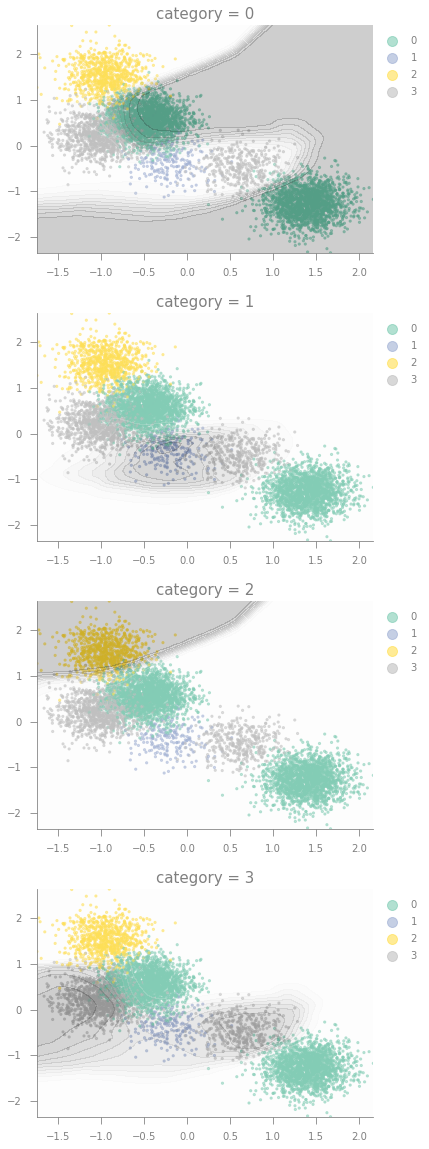

In [127]:
def plot_prediction_grid(model, 
                         X, y, 
                         n, 
                         cmap = 'Set2') -> None:
    
    categories = np.unique(y)
    n_categories = len(categories)
    
    def generate_grids(X, n):
        space_range = zip(
            np.min(X, axis = 0).tolist(), 
            np.max(X, axis = 0).tolist()
        )
        space = list(map(
            lambda x: np.linspace(*x, num = n), space_range
        ))
        meshgrid = np.meshgrid(*space)
        grid_flat = np.column_stack(
            list(map(lambda x: np.ravel(x), meshgrid))
        )   
        return meshgrid, grid_flat

    meshgrid, grid_flat = generate_grids(X, n)
    
    grid_tensor = grid_flat.astype(params['dtypes']['X'])
    grid_tensor = (
        torch.from_numpy(grid_tensor)
        .to(params['device'])
    )
    
    model.eval() 
    with torch.autograd.inference_mode(mode=True):
        grid_flat_pred = (
            model(grid_tensor)
            .softmax(1)
            .to(device = 'cpu')
        )

    
    fig, ax = plt.subplots(
        n_categories, 1, 
        figsize = (6, n_categories * 4), 
        constrained_layout = True
    )
    
    for i, category in enumerate(categories):
        category_prob = (
            grid_flat_pred[:, i]
            .reshape(meshgrid[0].shape)
        )
        
        p = ax[i].scatter(
            *X.T, 
            c=y, 
            alpha = 0.5,
            cmap=cmap, 
            s=5
        )
        _ = ax[i].legend(
            *p.legend_elements(prop='colors', size=10),
            bbox_to_anchor=(1,1)
        )
        _ = ax[i].contourf(
            *meshgrid, 
            category_prob, 
            alpha = 0.2, 
            cmap = 'Greys', 
            levels = 10
        )
        ax[i].set_title(f'category = {i}')

plot_prediction_grid(blobs_classifier, X_train, y_train, 50)